In [2]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

/Users/alanwang/opt/anaconda3/envs/tf/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Get data
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url,
                                   fname='flower_photos',
                                   untar=True)
data_dir = pathlib.Path(data_dir)

image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

228827136/228813984 [==============================] - 61s 0us/step
3670


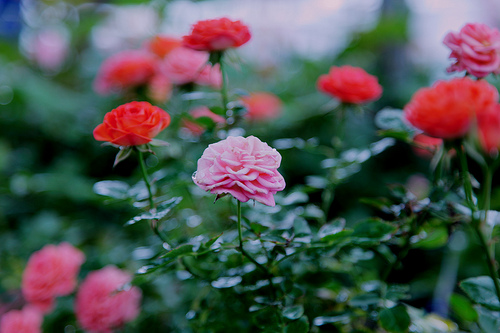

In [6]:
# display image
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[1]))

# Loading from keras image_dataset_from_directory 

In [7]:
batch_size = 32
img_height = 180
img_width = 180

# 80-20 validiation split 
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names
print(class_names)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.
['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


2022-07-07 15:53:38.907741: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


(32, 180, 180, 3)
(32,)


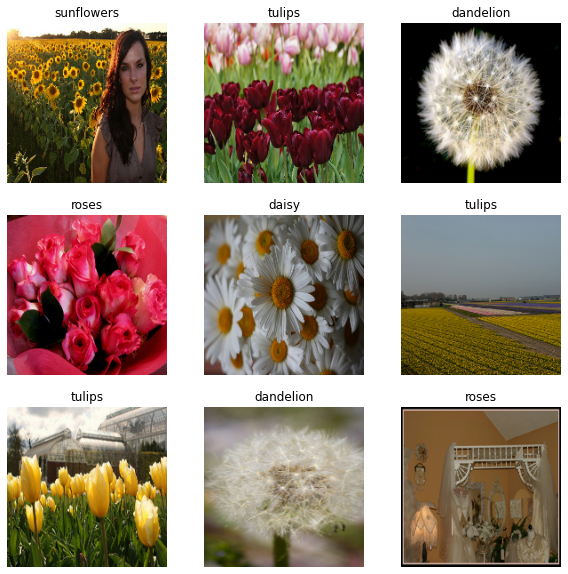

In [11]:
# Visualize the data
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
        
# Shapes
for image_batch, labels_batch in train_ds:
    print(image_batch.shape) # 32   180*10*3 images (3 is RGB)
    print(labels_batch.shape)
    break

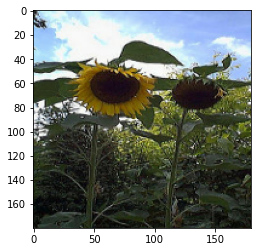

0.0 1.0


In [13]:
# Rescaling using keras 
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
plt.imshow(first_image)
plt.show()
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

In [15]:
# performance enhancement
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [17]:
# model
def build_model(num_classes=5):
    model = tf.keras.Sequential([
      tf.keras.layers.Rescaling(1./255),
      tf.keras.layers.Conv2D(32, 3, activation='relu'),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Conv2D(32, 3, activation='relu'),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Conv2D(32, 3, activation='relu'),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(num_classes)
    ])

    model.compile(
      optimizer='adam',
      loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
      metrics=['accuracy'])

    return model

In [18]:
# train
model = build_model() 
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3
92/92 [==============================] - 29s 306ms/step - loss: 1.2711 - accuracy: 0.4649 - val_loss: 1.0604 - val_accuracy: 0.5967
Epoch 2/3
92/92 [==============================] - 28s 304ms/step - loss: 1.0035 - accuracy: 0.6114 - val_loss: 0.9668 - val_accuracy: 0.6117
Epoch 3/3
92/92 [==============================] - 43s 469ms/step - loss: 0.8574 - accuracy: 0.6771 - val_loss: 0.8612 - val_accuracy: 0.6662


In [19]:
# Evaluation 
model.evaluate(val_ds)

23/23 [==============================] - 2s 76ms/step - loss: 0.8612 - accuracy: 0.6662


[0.8612210154533386, 0.6662125587463379]

# tf.data for finer control

In [32]:
# Get data
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)
for f in list_ds.take(10):
    print(f.numpy())

# class names
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)

b'/Users/alanwang/.keras/datasets/flower_photos/daisy/162362897_1d21b70621_m.jpg'
b'/Users/alanwang/.keras/datasets/flower_photos/tulips/5433747333_869a2a172d_m.jpg'
b'/Users/alanwang/.keras/datasets/flower_photos/daisy/2607132536_d95198e619_n.jpg'
b'/Users/alanwang/.keras/datasets/flower_photos/dandelion/7808545612_546cfca610_m.jpg'
b'/Users/alanwang/.keras/datasets/flower_photos/sunflowers/19508264965_d1dfb565ea_n.jpg'
b'/Users/alanwang/.keras/datasets/flower_photos/sunflowers/2443921986_d4582c123a.jpg'
b'/Users/alanwang/.keras/datasets/flower_photos/tulips/10094729603_eeca3f2cb6.jpg'
b'/Users/alanwang/.keras/datasets/flower_photos/tulips/9976515506_d496c5e72c.jpg'
b'/Users/alanwang/.keras/datasets/flower_photos/roses/9338237628_4d2547608c.jpg'
b'/Users/alanwang/.keras/datasets/flower_photos/roses/15174615529_144ae28bdb_n.jpg'
['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


In [33]:
# split train and validation
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

2936
734


In [34]:
# encode label 
def get_label(file_path):
    # Convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    one_hot = parts[-2] == class_names # creates an list of size 5 with 1 where it is equal i.e. [0, 0, 0, 1, 0]
    # Integer encode the label
    return tf.argmax(one_hot)

# Decode img 
def decode_img(img):
    # Convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_jpeg(img, channels=3)
    # Resize the image to the desired size
    return tf.image.resize(img, [img_height, img_width])

# Load label and image data 
def process_path(file_path):
    label = get_label(file_path)
    # Load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [35]:
# Get data from files and preprocess
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE) # We need to extract from file path 
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  3


In [36]:
# performance configuration
def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

2022-07-07 16:35:14.582535: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


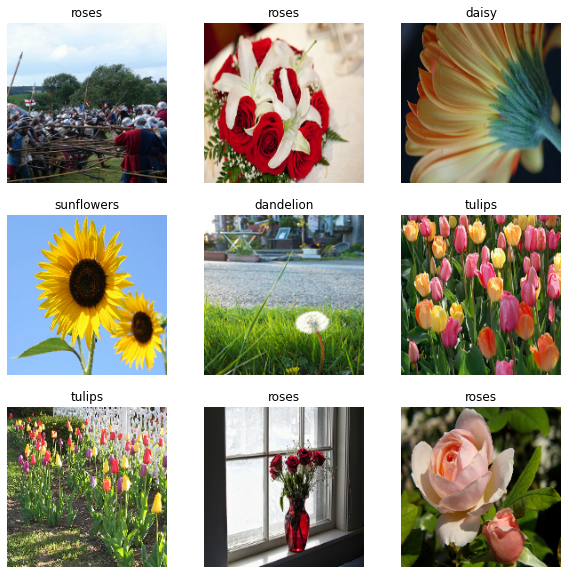

In [37]:
# visualize the data
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    label = label_batch[i]
    plt.title(class_names[label])
    plt.axis("off")

In [38]:
# Train model
model = build_model() 
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3
92/92 [==============================] - 28s 291ms/step - loss: 1.3027 - accuracy: 0.4414 - val_loss: 1.1322 - val_accuracy: 0.5572
Epoch 2/3
92/92 [==============================] - 27s 293ms/step - loss: 1.0078 - accuracy: 0.6073 - val_loss: 1.0692 - val_accuracy: 0.5967
Epoch 3/3
92/92 [==============================] - 41s 449ms/step - loss: 0.8559 - accuracy: 0.6764 - val_loss: 1.0133 - val_accuracy: 0.6063


In [39]:
# Evaluate 
model.evaluate(val_ds)

23/23 [==============================] - 2s 72ms/step - loss: 1.0133 - accuracy: 0.6063


[1.0132567882537842, 0.6062670350074768]

# Tensorflow datasets

In [40]:
# Get data and split 
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

num_classes = metadata.features['label'].num_classes
print(num_classes)

2022-07-07 16:41:08.906829: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "Not found: Could not locate the credentials file.". Retrieving token from GCE failed with "Failed precondition: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


Dl Completed...: 100%|█████████████████████████| 5/5 [00:51<00:00, 10.27s/ file]


Dataset tf_flowers downloaded and prepared to ~/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.
5


2022-07-07 16:44:55.313378: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


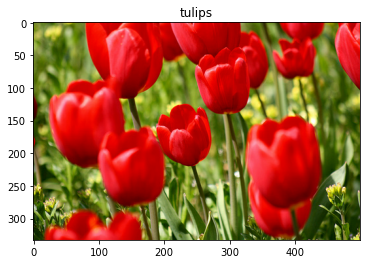

In [42]:
# get label 
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

In [43]:
# configure performance 
train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)
test_ds = configure_for_performance(test_ds)

In [45]:
# go to data augmentation tutorial to finsih the training (build_model() does not work)